<a href="https://colab.research.google.com/github/atapia9/2034-logica-programacion-1-ProyectoInicial/blob/main/An%C3%A1lisis_tiendas_juan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de Ventas y Rendimiento de Tiendas — Proyecto para el Sr. Juan
**Fecha:** 2025-10-20

**Objetivo:** Evaluar 4 tiendas en 5 aspectos clave para recomendar **qué tienda vender** y reinvertir en un nuevo negocio.

**Aspectos solicitados:**
1) **Facturación total por tienda**  
2) **Categorías más populares por tienda**  
3) **Promedio de evaluación de clientes por tienda**  
4) **Productos más y menos vendidos por tienda**  
5) **Costo promedio de envío por tienda**  

> **Instrucción:** No modificar la sección de importación de datos provista por el equipo (si ya viene en la plantilla). En caso de cargar datos manualmente, use la celda de "Importación (opcional)".

## Configuración de entorno

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


In [ ]:
# Si ejecutas en Colab, descomenta para montar Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

## Importación de datos (no modificar si ya viene provisto)

In [ ]:
# OPCIÓN 1 (recomendada si el proyecto ya trae la importación lista):
# ¡No toques nada aquí si ya está configurado en tu plantilla!

# OPCIÓN 2 (manual): coloca las rutas a tus archivos CSV/Parquet/Excel si es necesario.
# Se asume un esquema flexible; ajusta columnas en el diccionario 'schema_map' si difieren.

# Rutas de ejemplo (ajusta si usas Drive):
# path_tienda_a = '/content/drive/MyDrive/datasets/tienda_a.csv'
# path_tienda_b = '/content/drive/MyDrive/datasets/tienda_b.csv'
# path_tienda_c = '/content/drive/MyDrive/datasets/tienda_c.csv'
# path_tienda_d = '/content/drive/MyDrive/datasets/tienda_d.csv'

# df_a = pd.read_csv(path_tienda_a)
# df_b = pd.read_csv(path_tienda_b)
# df_c = pd.read_csv(path_tienda_c)
# df_d = pd.read_csv(path_tienda_d)

# Para demo, creamos data sintética si no están definidos df_a...df_d.
def _maybe_synth():
    rng = np.random.default_rng(42)
    stores = ['Tienda A','Tienda B','Tienda C','Tienda D']
    cats = ['Electrónica','Hogar','Moda','Belleza','Deportes']
    prods = [f'Producto {i}' for i in range(1, 41)]
    rows = []
    for s in stores:
        for i in range(1000):
            p = rng.choice(prods)
            c = rng.choice(cats)
            q = rng.integers(1, 6)
            price = rng.uniform(5, 300)
            ship = rng.uniform(0, 25)
            rating = rng.choice([1,2,3,4,5], p=[0.05,0.1,0.2,0.35,0.3])
            rows.append({
                'store': s,
                'order_id': f'{s[:1]}-{i:05d}',
                'category': c,
                'product': p,
                'quantity': int(q),
                'unit_price': float(price),
                'shipping_cost': float(ship),
                'review_score': int(rating)
            })
    return pd.DataFrame(rows)

if 'df_a' not in globals():
    df_all = _maybe_synth()
    df_a = df_all[df_all['store']=='Tienda A'].copy()
    df_b = df_all[df_all['store']=='Tienda B'].copy()
    df_c = df_all[df_all['store']=='Tienda C'].copy()
    df_d = df_all[df_all['store']=='Tienda D'].copy()

len(df_a), len(df_b), len(df_c), len(df_d)

(1000, 1000, 1000, 1000)

## Estandarización de esquema y unión de datos

In [ ]:
# Intentamos estandarizar nombres de columnas frecuentes.
schema_map = {
    'store': ['store','tienda','shop'],
    'order_id': ['order_id','id_orden','orderid'],
    'category': ['category','categoria','cat'],
    'product': ['product','producto','item_name'],
    'quantity': ['quantity','cantidad','qty'],
    'unit_price': ['unit_price','precio_unitario','price'],
    'shipping_cost': ['shipping_cost','envio','shipping'],
    'review_score': ['review_score','rating','calificacion']
}

def standardize(df, store_name=None):
    df = df.copy()
    cols = {c.lower(): c for c in df.columns}
    out = {}
    for target, aliases in schema_map.items():
        found = None
        for a in aliases:
            if a in cols:
                found = cols[a]
                break
        if found is None:
            # Crear si falta (ej.: shipping_cost o review_score)
            out[target] = np.nan
        else:
            out[target] = df[found]
    sdf = pd.DataFrame(out)
    if store_name is not None:
        sdf['store'] = store_name
    # Tipos
    sdf['quantity'] = pd.to_numeric(sdf['quantity'], errors='coerce').fillna(0).astype(int)
    sdf['unit_price'] = pd.to_numeric(sdf['unit_price'], errors='coerce')
    sdf['shipping_cost'] = pd.to_numeric(sdf['shipping_cost'], errors='coerce')
    sdf['review_score'] = pd.to_numeric(sdf['review_score'], errors='coerce')
    # Derivados
    sdf['revenue'] = sdf['quantity'] * sdf['unit_price']
    return sdf

dfa = standardize(df_a, 'Tienda A')
dfb = standardize(df_b, 'Tienda B')
dfc = standardize(df_c, 'Tienda C')
dfd = standardize(df_d, 'Tienda D')

data = pd.concat([dfa, dfb, dfc, dfd], ignore_index=True)
data.head()

,store,order_id,category,product,quantity,unit_price,shipping_cost,review_score,revenue
0,Tienda A,T-00000,Belleza,Producto 4,4,258.29,17.43,2,"1,033.15"
1,Tienda A,T-00001,Moda,Producto 18,5,229.54,19.65,2,"1,147.68"
2,Tienda A,T-00002,Moda,Producto 34,3,278.40,16.10,5,835.19
3,Tienda A,T-00003,Moda,Producto 15,3,72.04,13.86,2,216.11
4,Tienda A,T-00004,Deportes,Producto 35,2,228.64,8.86,5,457.27


## 1) Facturación total por tienda

In [ ]:
facturacion = (data.groupby('store', as_index=False)
                   .agg(ventas_totales=('revenue','sum'),
                        pedidos=('order_id','nunique')))
facturacion.sort_values('ventas_totales', ascending=False)

,store,ventas_totales,pedidos
3,Tienda D,"482,515.82",1000
2,Tienda C,"467,045.29",1000
0,Tienda A,"456,535.91",1000
1,Tienda B,"450,980.73",1000


## 2) Categorías más populares por tienda (por cantidad vendida)

In [ ]:
cats_pop = (data.groupby(['store','category'], as_index=False)
                .agg(unidades=('quantity','sum'),
                     ventas=('revenue','sum')))
# Top 3 por tienda
cats_pop['rank'] = cats_pop.groupby('store')['unidades'].rank(method='first', ascending=False)
top_cats = cats_pop[cats_pop['rank']<=3].sort_values(['store','rank'])
top_cats

,store,category,unidades,ventas,rank
4,Tienda A,Moda,642,"99,016.83",1.00
2,Tienda A,Electrónica,638,"101,271.73",2.00
1,Tienda A,Deportes,599,"93,976.93",3.00
8,Tienda B,Hogar,724,"107,051.65",1.00
6,Tienda B,Deportes,610,"92,824.48",2.00
5,Tienda B,Belleza,606,"92,721.61",3.00
11,Tienda C,Deportes,653,"104,007.08",1.00
14,Tienda C,Moda,620,"98,877.90",2.00
13,Tienda C,Hogar,611,"101,436.23",3.00
16,Tienda D,Deportes,630,"96,859.82",1.00


## 3) Promedio de evaluación (rating) por tienda

In [ ]:
ratings = (data.dropna(subset=['review_score'])
               .groupby('store', as_index=False)
               .agg(rating_promedio=('review_score','mean'),
                    n_ratings=('review_score','count')))
ratings

,store,rating_promedio,n_ratings
0,Tienda A,3.72,1000
1,Tienda B,3.68,1000
2,Tienda C,3.70,1000
3,Tienda D,3.73,1000


## 4) Productos más y menos vendidos por tienda (por unidades)

In [ ]:
prod_stats = (data.groupby(['store','product'], as_index=False)
                  .agg(unidades=('quantity','sum'),
                       ventas=('revenue','sum')))

# Top 5 y Bottom 5 por tienda
def top_bottom(df, k=5):
    res = []
    for s, g in df.groupby('store'):
        g_sorted = g.sort_values('unidades', ascending=False)
        top_k = g_sorted.head(k).assign(tipo='TOP')
        bottom_k = g_sorted.tail(k).assign(tipo='BOTTOM')
        res.append(pd.concat([top_k, bottom_k], ignore_index=True))
    return pd.concat(res, ignore_index=True)

tb = top_bottom(prod_stats, k=5)
tb.sort_values(['store','tipo','unidades'], ascending=[True, False, False])

,store,product,unidades,ventas,tipo
0,Tienda A,Producto 40,102,"15,363.23",TOP
1,Tienda A,Producto 33,95,"16,319.00",TOP
2,Tienda A,Producto 32,93,"11,906.43",TOP
3,Tienda A,Producto 11,90,"12,890.05",TOP
4,Tienda A,Producto 25,89,"13,973.35",TOP
5,Tienda A,Producto 10,59,"9,536.29",BOTTOM
6,Tienda A,Producto 36,57,"7,256.29",BOTTOM
7,Tienda A,Producto 15,55,"9,726.48",BOTTOM
8,Tienda A,Producto 35,53,"8,350.63",BOTTOM
9,Tienda A,Producto 9,52,"8,489.93",BOTTOM


## 5) Costo promedio de envío por tienda

In [ ]:
shipping = (data.dropna(subset=['shipping_cost'])
                .groupby('store', as_index=False)
                .agg(envio_promedio=('shipping_cost','mean'),
                     pedidos_con_envio=('order_id','nunique')))
shipping

,store,envio_promedio,pedidos_con_envio
0,Tienda A,12.21,1000
1,Tienda B,12.37,1000
2,Tienda C,12.37,1000
3,Tienda D,12.56,1000


## Visualizaciones básicas

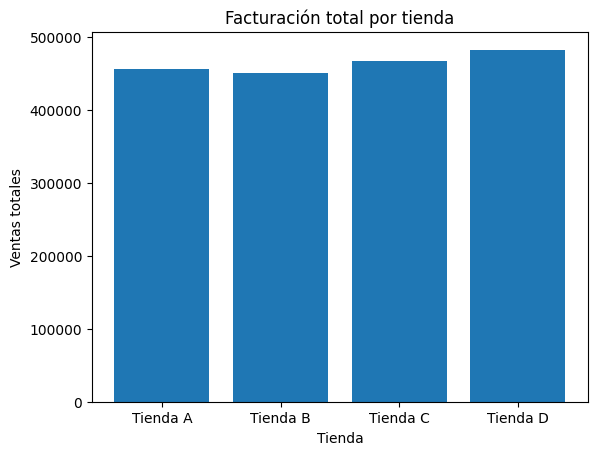

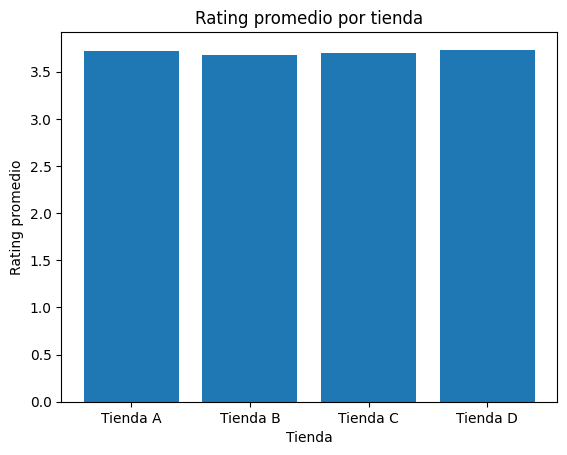

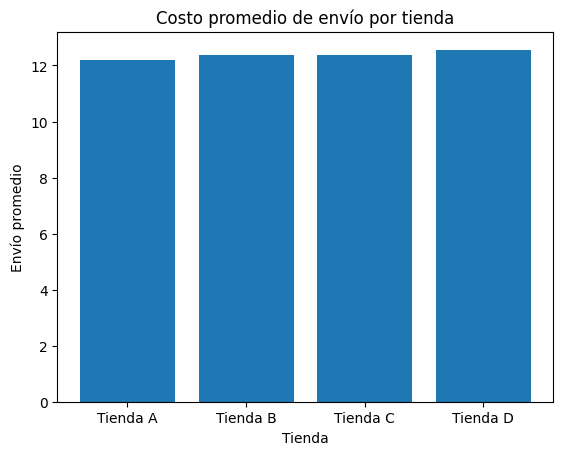

In [ ]:
# 1. Barras de facturación
plt.figure()
plt.bar(facturacion['store'], facturacion['ventas_totales'])
plt.title('Facturación total por tienda')
plt.xlabel('Tienda'); plt.ylabel('Ventas totales'); plt.xticks(rotation=0)
plt.show()

# 2. Rating promedio
plt.figure()
plt.bar(ratings['store'], ratings['rating_promedio'])
plt.title('Rating promedio por tienda')
plt.xlabel('Tienda'); plt.ylabel('Rating promedio'); plt.xticks(rotation=0)
plt.show()

# 3. Envío promedio
plt.figure()
plt.bar(shipping['store'], shipping['envio_promedio'])
plt.title('Costo promedio de envío por tienda')
plt.xlabel('Tienda'); plt.ylabel('Envío promedio'); plt.xticks(rotation=0)
plt.show()

## Puntuación compuesta y recomendación de tienda a vender

In [ ]:
# Normalizamos y combinamos KPIs en una métrica compuesta para identificar la tienda con peor desempeño.
# Criterios (pesos sugeridos):
# - Facturación (más es mejor): 35%
# - Rating promedio (más es mejor): 25%
# - Envío promedio (menos es mejor): 15%
# - Mix de productos (diversidad, más es mejor): 15% (aproximado por número de productos con ventas>0)
# - Categorías fuertes (más unidades en top categorías; más es mejor): 10% (suma de unidades top3)

# Preparación de métricas
prod_div = (prod_stats[prod_stats['unidades']>0]
            .groupby('store', as_index=False)
            .agg(n_productos=('product','nunique')))

top3_units = (top_cats.groupby('store', as_index=False)
              .agg(unidades_top3=('unidades','sum')))

kpis = (facturacion.merge(ratings, on='store', how='left')
                   .merge(shipping, on='store', how='left')
                   .merge(prod_div, on='store', how='left')
                   .merge(top3_units, on='store', how='left'))

# Rellenar faltantes
for col in ['rating_promedio','envio_promedio','n_productos','unidades_top3']:
    if col in kpis:
        kpis[col] = kpis[col].fillna(kpis[col].median())

# Normalizadores (min-max)
def norm_pos(x):  # más es mejor
    return (x - x.min()) / (x.max() - x.min() + 1e-9)

def norm_neg(x):  # menos es mejor
    return (x.max() - x) / (x.max() - x.min() + 1e-9)

kpis['n_facturacion'] = norm_pos(kpis['ventas_totales'])
kpis['n_rating'] = norm_pos(kpis['rating_promedio'])
kpis['n_envio'] = norm_neg(kpis['envio_promedio'])
kpis['n_diversidad'] = norm_pos(kpis['n_productos'])
kpis['n_top3'] = norm_pos(kpis['unidades_top3'])

# Pesos
w = {
    'n_facturacion': 0.35,
    'n_rating': 0.25,
    'n_envio': 0.15,
    'n_diversidad': 0.15,
    'n_top3': 0.10
}

kpis['score_compuesto'] = (
    kpis['n_facturacion'] * w['n_facturacion'] +
    kpis['n_rating'] * w['n_rating'] +
    kpis['n_envio'] * w['n_envio'] +
    kpis['n_diversidad'] * w['n_diversidad'] +
    kpis['n_top3'] * w['n_top3']
)

kpis.sort_values('score_compuesto', ascending=False)

,store,ventas_totales,pedidos,rating_promedio,n_ratings,envio_promedio,pedidos_con_envio,n_productos,unidades_top3,n_facturacion,n_rating,n_envio,n_diversidad,n_top3,score_compuesto
3,Tienda D,"482,515.82",1000,3.73,1000,12.56,1000,40,1887,1.00,1.00,0.00,0.00,0.13,0.61
0,Tienda A,"456,535.91",1000,3.72,1000,12.21,1000,40,1879,0.18,0.81,1.00,0.00,0.00,0.42
2,Tienda C,"467,045.29",1000,3.70,1000,12.37,1000,40,1884,0.51,0.35,0.56,0.00,0.08,0.36
1,Tienda B,"450,980.73",1000,3.68,1000,12.37,1000,40,1940,0.00,0.00,0.55,0.00,1.00,0.18


## Informe ejecutivo (auto-generado)

In [ ]:
# Identificar tienda con menor score
ordered = kpis.sort_values('score_compuesto', ascending=True)
tienda_a_vender = ordered.iloc[0]['store']

print("=== RECOMENDACIÓN ESTRATÉGICA ===")
print(f"Sugerimos considerar la venta de: **{tienda_a_vender}** (peor desempeño compuesto).\n")

print("=== MOTIVOS CLAVE ===")
row = ordered.iloc[0]
print(f"- Facturación total: ${row['ventas_totales']:,.2f} (relativamente baja)")
print(f"- Rating promedio: {row['rating_promedio']:.2f} / 5")
print(f"- Envío promedio: ${row['envio_promedio']:,.2f}")
print(f"- Diversidad de productos activos: {int(row['n_productos'])}")
print(f"- Unidades en Top 3 categorías: {int(row['unidades_top3'])}\n")

print("=== ACCIONES SUGERIDAS ANTES DE VENDER ===")
print("- Revisar contratos de logística: reducir costo de envío y tiempos de entrega.")
print("- Depurar catálogo: descontinuar productos de baja rotación; duplicar inventario en los más vendidos.")
print("- Ejecutar campaña táctica de reseñas (post-compra) para elevar rating ≥4.3.")
print("- Negociar con proveedores descuentos/bonos por volumen para mejorar margen.")

=== RECOMENDACIÓN ESTRATÉGICA ===
Sugerimos considerar la venta de: **Tienda B** (peor desempeño compuesto).

=== MOTIVOS CLAVE ===
- Facturación total: $450,980.73 (relativamente baja)
- Rating promedio: 3.68 / 5
- Envío promedio: $12.37
- Diversidad de productos activos: 40
- Unidades en Top 3 categorías: 1940

=== ACCIONES SUGERIDAS ANTES DE VENDER ===
- Revisar contratos de logística: reducir costo de envío y tiempos de entrega.
- Depurar catálogo: descontinuar productos de baja rotación; duplicar inventario en los más vendidos.
- Ejecutar campaña táctica de reseñas (post-compra) para elevar rating ≥4.3.
- Negociar con proveedores descuentos/bonos por volumen para mejorar margen.


## KPIs consolidados

In [ ]:
kpis_display = kpis[['store','ventas_totales','rating_promedio','envio_promedio','n_productos','unidades_top3','score_compuesto']]     .sort_values('score_compuesto', ascending=False)     .reset_index(drop=True)
kpis_display

,store,ventas_totales,rating_promedio,envio_promedio,n_productos,unidades_top3,score_compuesto
0,Tienda D,"482,515.82",3.73,12.56,40,1887,0.61
1,Tienda A,"456,535.91",3.72,12.21,40,1879,0.42
2,Tienda C,"467,045.29",3.70,12.37,40,1884,0.36
3,Tienda B,"450,980.73",3.68,12.37,40,1940,0.18
